## Этап 1. Открываю данные и получаю общую информацию о датасете

### Импортирую библиотеки

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
import warnings

In [2]:
try:
    df = pd.read_csv('taxi.csv')
except:
    df = pd.read_csv('/datasets/taxi.csv')

In [3]:
df.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [4]:
#смотрю общую информацию о данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


### Оцениваю количество пропусков

In [5]:
def isna(data):
    data_isna = data.isna().sum()
    data_isna_percentage = ((data_isna / len(data)) * 100).round(2)
    data_isna_df = pd.DataFrame({
    'Количество пропусков': data_isna,
    'Процент пропусков': data_isna_percentage
}) 
    return data_isna_df[(data_isna_df['Количество пропусков'] > 0)].sort_values(
        by='Количество пропусков', ascending=False)

In [6]:
df_isna = isna(df)
df_isna

,Количество пропусков,Процент пропусков


In [7]:
#проверка датафрейма на дубликаты
df.duplicated().sum()

0

### Изменение типов данных

In [8]:
#меняю тип данных в столбце с датой на формат datetime
df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d %H:%M:%S')

In [9]:
#проверяю тип данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


In [10]:
#устанавливаем данные из datetime в качестве индекса
df = df.set_index('datetime')

In [11]:
#проверяем даты/время на хронологический порядок
df.index.is_monotonic

True

In [12]:
#производим ресемплирование по 1 часу
df = df.resample('1H').sum()

### Вывод

В рамках подготовки данных:
- Было выявлено, что данные не содержат пропуски и дубликаты;
- Изменен тип данных для даты на datetime;
- Данные datetime установлены в качестве индекса;
- Данные расположены в хронологическом порядке;
- Произведен ресемплинг данных в интервале 1 час.


## Этап 2. Анализ данных

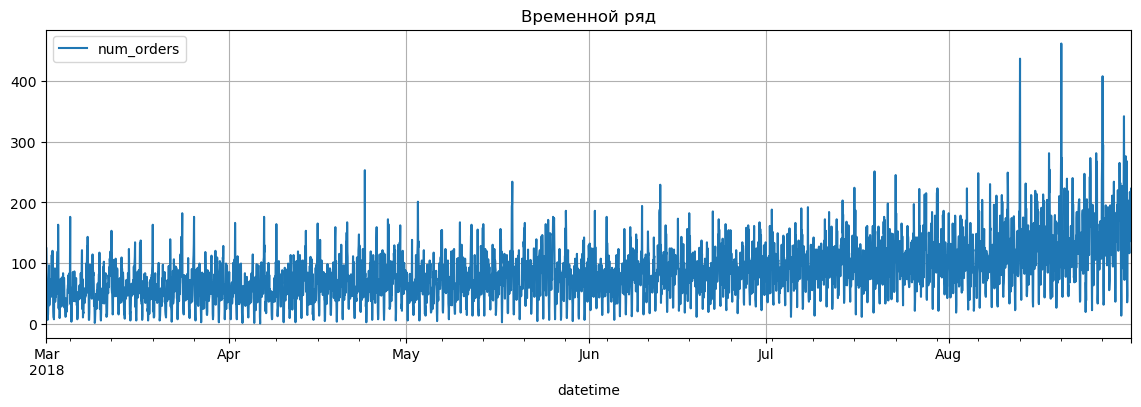

In [13]:
#визуализирую временной ряд
df.plot(figsize=(14,4))
plt.title('Временной ряд')
plt.grid()
plt.show()

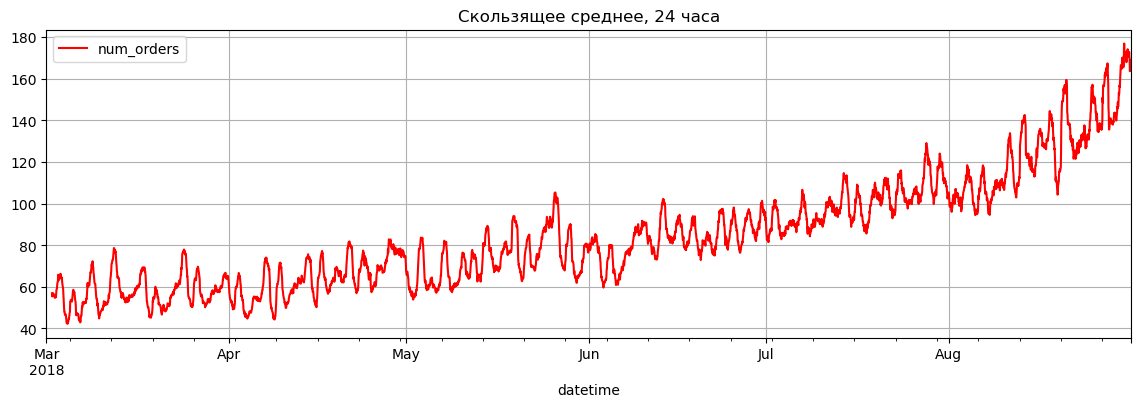

In [14]:
#визуализирую скользящее среднее размером 24 часа
df.rolling(24).mean().plot(figsize=(14,4), color='red')
plt.title('Скользящее среднее, 24 часа')
plt.grid()
plt.show()

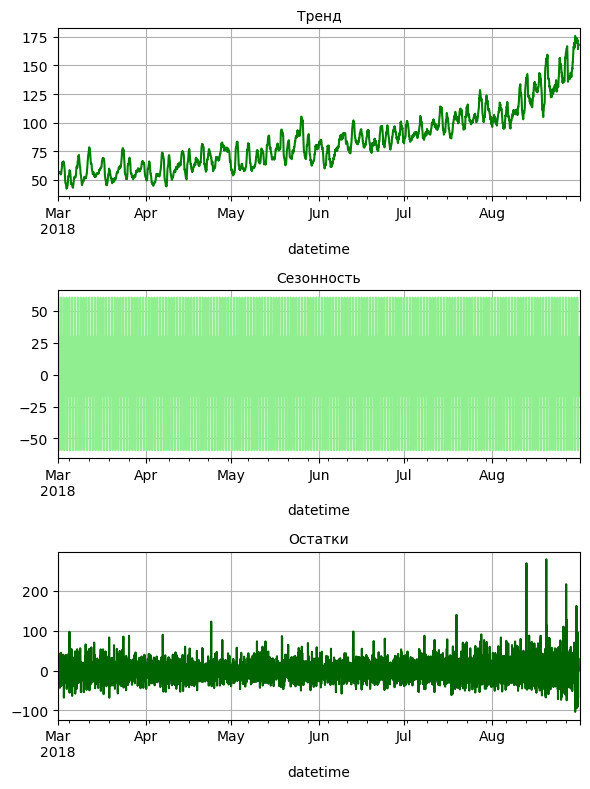

In [15]:
#рассмотрим тренды/сезонность
decomposed_df = seasonal_decompose(df)
plt.figure(figsize=(6,8))
plt.subplot(311)
decomposed_df.trend.plot(ax=plt.gca(), color='green')
plt.title('Тренд', fontsize=10)
plt.grid()
plt.subplot(312)
decomposed_df.seasonal.plot(ax=plt.gca(), color='lightgreen')
plt.title('Сезонность', fontsize=10)
plt.grid()
plt.subplot(313)
decomposed_df.resid.plot(ax=plt.gca(), color='darkgreen')
plt.title('Остатки', fontsize=10)
plt.tight_layout()
plt.grid()
plt.show()

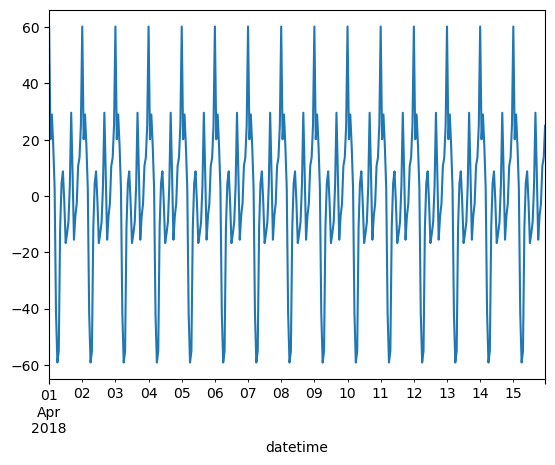

In [16]:
#рассмотрим сезонность на 2-недельном интервале
decomposed_df.seasonal['2018-04-01':'2018-04-15'].plot(ax=plt.gca())
plt.show()

#### Вижу восходящий тренд, усиливающийся летом.

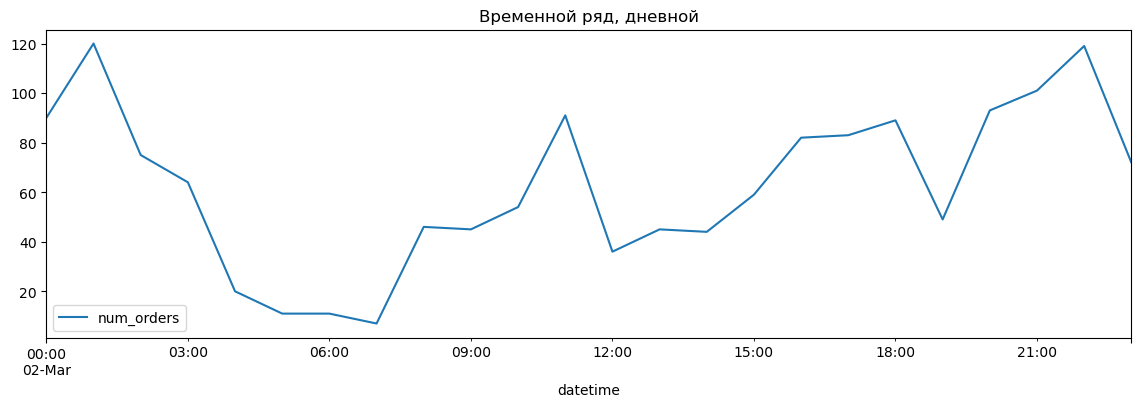

In [17]:
#рассмотрю дополнительно срез произвольного дня
df['2018-03-02':'2018-03-02'].plot(figsize=(14,4))
plt.title('Временной ряд, дневной')
plt.show()

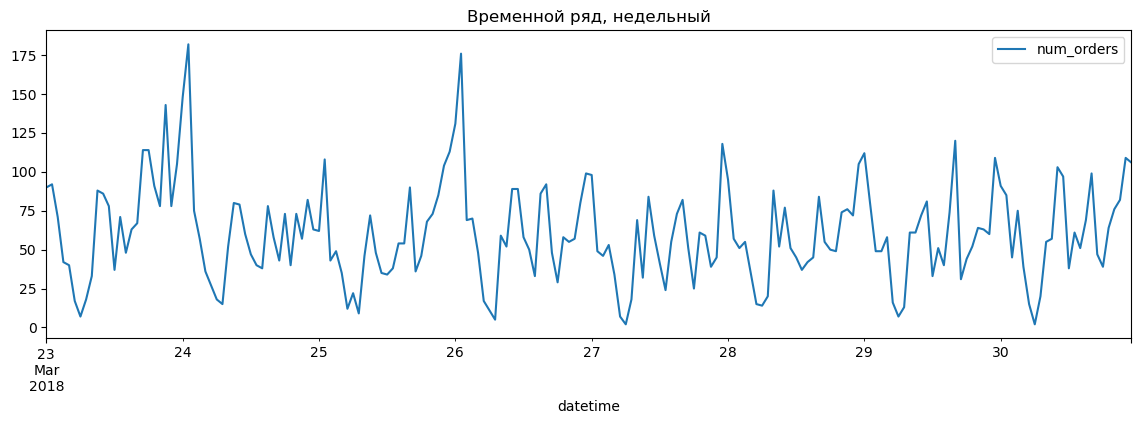

In [18]:
#также дополнительно рассмотрю срез произвольной недели
df['2018-03-23':'2018-03-30'].plot(figsize=(14,4))
plt.title('Временной ряд, недельный')
plt.show()

In [19]:
#добавлю столбец с днями недели и сгруппирую по ним данные
df1 = df.copy()
df1['dayofweek'] = df1.index.dayofweek
df1.groupby('dayofweek')['num_orders'].mean().sort_values(ascending=False)

dayofweek
4    91.140432
0    90.246795
3    85.660494
5    83.847756
2    83.754808
6    78.991987
1    77.011218
Name: num_orders, dtype: float64

In [20]:
#аналогично проанализирую данные по часам
df1['hour'] = df1.index.hour
df1.groupby('hour')['num_orders'].mean().sort_values(ascending=False)

hour
0     144.402174
16    114.146739
2     113.070652
23    109.766304
1     104.364130
3     102.021739
22     98.500000
21     95.211957
10     93.119565
17     92.722826
9      88.831522
15     87.945652
4      86.907609
11     82.489130
20     81.858696
19     77.336957
14     75.163043
8      73.048913
13     71.173913
18     69.358696
12     67.630435
5      42.630435
7      29.271739
6      25.173913
Name: num_orders, dtype: float64

### Вывод
В рамках анализа данных было выявлено:
- Cамые популярные дни для поездок - понедельник и пятница;
- Самый популярный интервал для поездок - поздний вечер/ночь с 21 до 3, самый непопулярный - раннее утро с 5 до 7;
- Глобально наблюдается восходящий тренд.

## Этап 3. Обучение моделей

In [21]:
#создаю фунцию для признаков
def make_features(data, max_lag, rolling_mean_size):
    data_new = data.copy()
    data_new['month'] = data_new.index.month
    data_new['day'] = data_new.index.day
    data_new['dayofweek'] = data_new.index.dayofweek
    data_new['hour'] = data_new.index.hour
    
    def add_lag_column(dataframe, lag):
        lag_column = 'lag_{}'.format(lag)
        
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=pd.errors.PerformanceWarning)
            
            dataframe[lag_column] = dataframe['num_orders'].shift(lag)
        
        return dataframe
    
    for lag in range(1, max_lag + 1):
        data_new = add_lag_column(data_new, lag)
    
    data_new['rolling_mean'] = data_new['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return data_new

In [22]:
df_new = make_features(df, 168, 12)

/var/folders/86/_g8k2m7573ddjv9tyf1l7gpm0000gn/T/ipykernel_85856/955781572.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_new['rolling_mean'] = data_new['num_orders'].shift().rolling(rolling_mean_size).mean()


In [23]:
#удаляю строки с пропусками после сдвига
df_new = df_new.dropna()

In [24]:
#определяю признаки и целевой признак
features = df_new.drop('num_orders', axis=1)
target = df_new['num_orders']

In [25]:
#разделим тестовую и обучающую выборки
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.1, shuffle=False)

In [26]:
#функция целевой метрики RMSE
def rmse(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    return mse ** 0.5

In [27]:
#задаем метрику качества для моделей
rmse_scorer = make_scorer(rmse, greater_is_better=False)

### LinearRegression

In [28]:
%%time
model_lr = LinearRegression()
cv_lr = TimeSeriesSplit(n_splits=5)
param_grid_lr = {'fit_intercept': [True, False]}
grid_model_lr = GridSearchCV(model_lr, param_grid_lr, cv=cv_lr, scoring=rmse_scorer)
grid_model_lr.fit(features_train, target_train)

CPU times: user 3.08 s, sys: 838 ms, total: 3.92 s
Wall time: 1.85 s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=LinearRegression(),
             param_grid={'fit_intercept': [True, False]},
             scoring=make_scorer(rmse, greater_is_better=False))

In [29]:
best_model_lr = grid_model_lr.best_estimator_

In [30]:
best_score_lr = abs(grid_model_lr.best_score_)

In [31]:
print('Лучшие гиперпараметры:', grid_model_lr.best_params_)
print('Лучший RMSE', best_score_lr)

Лучшие гиперпараметры: {'fit_intercept': False}
Лучший RMSE 22.628476584372358


### CatBoost

In [32]:
%%time
model_cat = CatBoostRegressor(verbose=False)
cv_cat = TimeSeriesSplit(n_splits=5)
param_grid_cat = {'iterations': [100, 150, 200],
                'learning_rate': [0.12, 0.06, 0.03],
                'depth': [4, 6, 8]}
grid_model_cat = GridSearchCV(model_cat, param_grid_cat, cv=cv_cat, scoring=rmse_scorer)
grid_model_cat.fit(features_train, target_train)

CPU times: user 11min 9s, sys: 39.3 s, total: 11min 48s
Wall time: 1min 57s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=<catboost.core.CatBoostRegressor object at 0x7fac8b536d90>,
             param_grid={'depth': [4, 6, 8], 'iterations': [100, 150, 200],
                         'learning_rate': [0.12, 0.06, 0.03]},
             scoring=make_scorer(rmse, greater_is_better=False))

In [33]:
best_model_cat = grid_model_cat.best_estimator_

In [34]:
best_score_cat = abs(grid_model_cat.best_score_)

In [35]:
print('Лучшие гиперпараметры:', grid_model_cat.best_params_)
print('Лучший RMSE', best_score_cat)

Лучшие гиперпараметры: {'depth': 4, 'iterations': 200, 'learning_rate': 0.06}
Лучший RMSE 22.488276319257245


### LightGBM

In [36]:
%%time
model_lgbm = LGBMRegressor()
cv_lgbm = TimeSeriesSplit(n_splits=5)
param_grid_lgbm = {'num_leaves': [20, 40, 60],
                  'learning_rate': [0.12, 0.06, 0.03],
                   'max_depth': [5, 10, 15]}
grid_model_lgbm = GridSearchCV(model_lgbm, param_grid_lgbm, cv=cv_lgbm, scoring=rmse_scorer)
grid_model_lgbm.fit(features_train, target_train)

CPU times: user 8min 25s, sys: 1min 37s, total: 10min 3s
Wall time: 2min 3s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=LGBMRegressor(),
             param_grid={'learning_rate': [0.12, 0.06, 0.03],
                         'max_depth': [5, 10, 15], 'num_leaves': [20, 40, 60]},
             scoring=make_scorer(rmse, greater_is_better=False))

In [37]:
best_model_lgbm = grid_model_lgbm.best_estimator_

In [38]:
best_score_lgbm = abs(grid_model_lgbm.best_score_)

In [39]:
print('Лучшие гиперпараметры:', grid_model_lgbm.best_params_)
print('Лучший RMSE', best_score_lgbm)

Лучшие гиперпараметры: {'learning_rate': 0.06, 'max_depth': 5, 'num_leaves': 40}
Лучший RMSE 22.778121320152888


### Анализ моделей

In [40]:
df_model = pd.DataFrame({'модель': ['linear regression', 'catboost', 'lightgbm'],
                        'rmse': [best_score_lr, best_score_cat , best_score_lgbm]})
df_model 

,модель,rmse
0,linear regression,22.628477
1,catboost,22.488276
2,lightgbm,22.778121


Таким образом, лучший результат показал catboost. Применим эту модель на тестовой выборке.

### Тестирование лучшей модели

#### CatBoost

In [41]:
pred_cat = best_model_cat.predict(features_test)
score_cat = rmse(target_test, pred_cat)
print('RMSE модели', score_cat)

RMSE модели 37.5904216427076


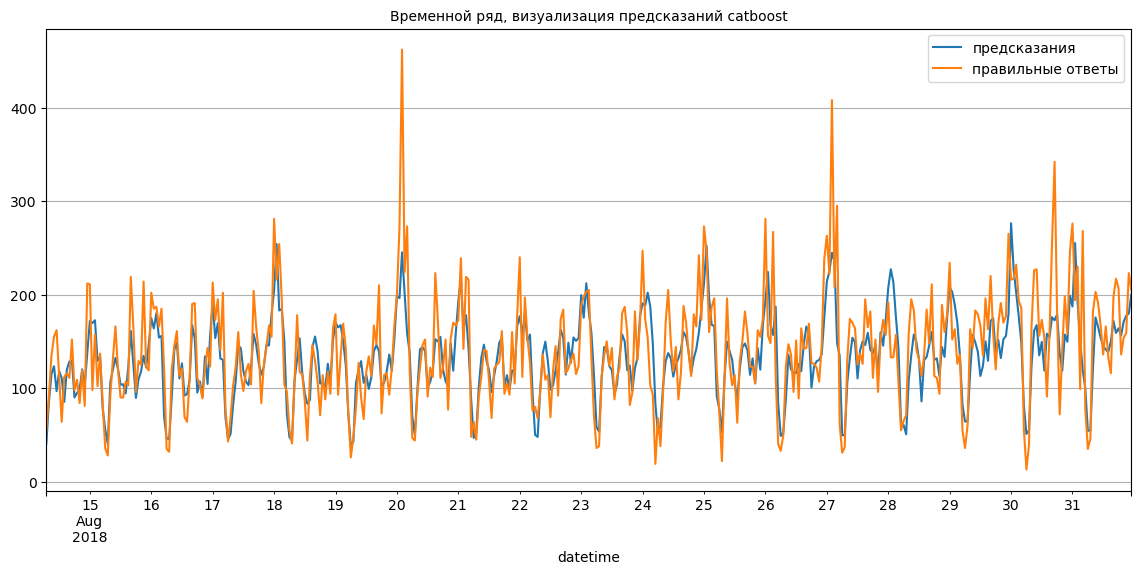

In [42]:
#визуализирую предсказания
df1 = pd.DataFrame(pred_cat, columns=['предсказания'])
df1.index = target_test.index
df1['правильные ответы'] = target_test
df1.plot(figsize=(14,6))
plt.grid()
plt.title('Временной ряд, визуализация предсказаний catboost', fontsize=10)
plt.show()

### Вывод

Была поставлена задача обучить модель и получить значение целевой метрики RMSE на тестовой выборке не более 48.

Для достижения поставленной цели были решены следующие задачи:
- Преобразованы данные относящиеся ко времени к типу datetime;
- Проведен анализ временных рядов, обнаружен восходящий тренд;
- Обнаружена сезонность внутри недели (количество поездок растет в понедельник и пятницу), а также внутри дня (количество поездок растет поздним вечером, наименьшие значения характерны для раннего утра);
- Подобраны лучшие гиперпараметры для моделей линейной регрессии, catboost, lightgbm;
- На тестовой выборке лучшая модель (catboost) показала значение RMSE < 48.